# Import and combine raw datasets

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt

d = './raw_data/'

In [2]:
# Function to convert all strings to lower case and strip names of spaces
def clean_str(x):
    if isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''

#### Import and merge datasets
We will import data from 3 distinct sources and attempt to combine them to generate the most complete dataset that we can.

In [31]:
# source 1: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv
movie_meta = pd.read_csv(d + "rounakbanik/movies_metadata.csv", 
                         converters={'id': lambda x: pd.to_numeric(x, errors='coerce'),
                                       'budget': lambda x: pd.to_numeric(x, errors='coerce'),
                                    'release_date': lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors = 'coerce')})
credits = pd.read_csv(d + "rounakbanik/credits.csv",
                           converters={'id': lambda x: pd.to_numeric(x, errors='coerce')})

# Merge movie meta data and credits, and remove duplicates
main_source = movie_meta.drop_duplicates(subset = "id").merge(credits.drop_duplicates(subset = "id"), 
                                                              on='id',
                                                             validate = 'one_to_one').drop_duplicates(subset = "imdb_id")

# source 2: https://www.kaggle.com/datasets/aditya126/movies-box-office-dataset-2000-2024
enhanced_boxoffice = pd.read_csv(d + "aditya126/enhanced_box_office_data(2000-2024)u.csv")

# source 3: https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre
imbd_genre_list = os.listdir(d + 'rajugc/')
imported_imbd_genre = []

for filename in imbd_genre_list:
    imported = pd.read_csv(d + 'rajugc/' + filename,
                          converters={'runtime': lambda x: pd.to_numeric(x, errors='coerce')})
    imported['rajugc_genre'] = filename[:-4]
    imported_imbd_genre.append(imported)

stacked_imbd_genre = pd.DataFrame(np.vstack(imported_imbd_genre), columns = imported_imbd_genre[0].columns.tolist()).drop_duplicates(subset = "movie_id")

# source 4
thenumbers_sample = pd.read_csv(d + "thenumbers/MovieData.csv",
                                converters={'production_budget': lambda x: pd.to_numeric(x, errors='coerce')}).drop_duplicates(subset = "movie_odid")
thenumbers_scrape = pd.read_csv(d + "thenumbers/numbers1.csv",
                                converters={'production_budget': lambda x: pd.to_numeric(x.replace('$', '').replace(',', ''), errors='coerce'),
                                            'domestic_gross': lambda x: pd.to_numeric(x.replace('$', '').replace(',', ''), errors='coerce'),
                                            'worldwide_gross': lambda x: pd.to_numeric(x.replace('$', '').replace(',', ''), errors='coerce'),
                                            'release_date': lambda x: pd.to_datetime(x, format='%d-%b-%y', errors = 'coerce')})
# Merge movie the numbers data and credits, and remove duplicates
thenumbers_sample['clean_movie_name'] = thenumbers_sample['movie_name'].apply(clean_str)
thenumbers_sample['year'] = thenumbers_sample['production_year'].astype(float)
thenumbers_scrape['year'] = thenumbers_scrape['release_date'].dt.year
thenumbers_scrape['clean_movie_title'] = thenumbers_scrape['movie_title'].apply(clean_str)

thenumbers_full = thenumbers_scrape.drop_duplicates(subset = ["clean_movie_title", 'release_date'], keep = False).merge(thenumbers_sample[['clean_movie_name', 'year','production_budget',
                                         'domestic_box_office','international_box_office', 'movie_odid','genre', 'running_time','rating']],
                                left_on=['clean_movie_title', 'year', 'production_budget'], 
                                right_on = ['clean_movie_name','year', 'production_budget'], 
                                how = 'left',
                                suffixes = (None, "_sample"),
                                validate = 'one_to_one')

/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_58732/3236367458.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_meta = pd.read_csv(d + "rounakbanik/movies_metadata.csv",


In [32]:
# Inspect data from source 1
main_source.info()
main_source.describe(include = "all").T

<class 'pandas.core.frame.DataFrame'>
Index: 45416 entries, 0 to 45431
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45416 non-null  object        
 1   belongs_to_collection  4486 non-null   object        
 2   budget                 45416 non-null  float64       
 3   genres                 45416 non-null  object        
 4   homepage               7773 non-null   object        
 5   id                     45416 non-null  float64       
 6   imdb_id                45415 non-null  object        
 7   original_language      45405 non-null  object        
 8   original_title         45416 non-null  object        
 9   overview               44464 non-null  object        
 10  popularity             45413 non-null  object        
 11  poster_path            45035 non-null  object        
 12  production_companies   45413 non-null  object        
 13  produc

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
adult,45416,2,False,45407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
belongs_to_collection,4486,1693,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budget,45416.0,NaN,NaN,NaN,4226075.207834,0.0,0.0,0.0,0.0,380000000.0,17431068.811523
genres,45416,4065,"[{'id': 18, 'name': 'Drama'}]",4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
homepage,7773,7669,http://www.georgecarlin.com,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,45416.0,NaN,NaN,NaN,108354.834574,2.0,26450.75,59994.0,157337.75,469172.0,112458.583528
imdb_id,45415,45415,tt0114709,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_language,45405,89,en,32239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,45416,43356,Hamlet,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,44464,44291,No overview found.,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Inspect data from source 2
enhanced_boxoffice.info()
enhanced_boxoffice.describe(include = "all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rank                  5000 non-null   int64  
 1   Release Group         5000 non-null   object 
 2   $Worldwide            5000 non-null   float64
 3   $Domestic             5000 non-null   float64
 4   Domestic %            5000 non-null   float64
 5   $Foreign              5000 non-null   float64
 6   Foreign %             5000 non-null   float64
 7   Year                  5000 non-null   int64  
 8   Genres                4822 non-null   object 
 9   Rating                4830 non-null   object 
 10  Vote_Count            4830 non-null   float64
 11  Original_Language     4830 non-null   object 
 12  Production_Countries  4800 non-null   object 
dtypes: float64(6), int64(2), object(5)
memory usage: 507.9+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,5000.0,NaN,NaN,NaN,100.5,57.74008,1.0,50.75,100.5,150.25,200.0
Release Group,5000,4955,Hero,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$Worldwide,5000.0,NaN,NaN,NaN,119213693.2098,200524343.217415,1666028.0,24662197.25,48446575.0,119758766.5,2799439100.0
$Domestic,5000.0,NaN,NaN,NaN,44725232.97,77270255.71366,0.0,92751.5,17984212.0,53868472.25,936662225.0
Domestic %,5000.0,NaN,NaN,NaN,35.74062,30.656992,0.0,0.2,37.05,57.8,100.0
$Foreign,5000.0,NaN,NaN,NaN,74488092.7352,133493209.856677,0.0,13710340.5,30194438.0,72115778.25,1993811448.0
Foreign %,5000.0,NaN,NaN,NaN,64.25664,30.654531,0.0,42.2,62.95,99.8,100.0
Year,5000.0,NaN,NaN,NaN,2012.0,7.211824,2000.0,2006.0,2012.0,2018.0,2024.0
Genres,4822,1317,Comedy,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,4830,1829,6.5/10,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Inspect data from source 3
stacked_imbd_genre.info()
stacked_imbd_genre.describe(include = "all").T

<class 'pandas.core.frame.DataFrame'>
Index: 243197 entries, 0 to 368299
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movie_id      243197 non-null  object
 1   movie_name    243195 non-null  object
 2   year          204294 non-null  object
 3   certificate   55092 non-null   object
 4   runtime       0 non-null       object
 5   genre         243197 non-null  object
 6   rating        138691 non-null  object
 7   description   243197 non-null  object
 8   director      222358 non-null  object
 9   director_id   222358 non-null  object
 10  star          198858 non-null  object
 11  star_id       204115 non-null  object
 12  votes         138693 non-null  object
 13  gross(in $)   12008 non-null   object
 14  rajugc_genre  243197 non-null  object
dtypes: object(15)
memory usage: 29.7+ MB


,count,unique,top,freq
movie_id,243197,243197,tt5433140,1
movie_name,243195,213572,Alone,35
year,204294,216,2022,7578
certificate,55092,42,Not Rated,16596
runtime,0,0,NaN,NaN
genre,243197,1745,Horror,16050
rating,138691.0,91.0,6.2,5050.0
description,243197,186759,Add a Plot,54449
director,222358,103466,Godfrey Ho,120
director_id,222358,96485,/name/nm0061792/,131


In [35]:
# Inspect data from source 4
thenumbers_full.info()
thenumbers_full.describe(include = "all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   rank                      6600 non-null   int64         
 1   release_date              6451 non-null   datetime64[ns]
 2   movie_title               6600 non-null   object        
 3   movie_url                 6600 non-null   object        
 4   production_budget         6600 non-null   int64         
 5   domestic_gross            6600 non-null   int64         
 6   worldwide_gross           6600 non-null   int64         
 7   year                      6451 non-null   float64       
 8   clean_movie_title         6600 non-null   object        
 9   clean_movie_name          1275 non-null   object        
 10  domestic_box_office       1275 non-null   float64       
 11  international_box_office  1275 non-null   float64       
 12  movie_odid          

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
rank,6600.0,NaN,NaN,NaN,3300.5,1.0,1650.75,3300.5,4950.25,6600.0,1905.40022
release_date,6451,NaN,NaN,NaN,2008-07-24 13:41:13.849015552,1969-04-01 00:00:00,2001-12-14 00:00:00,2009-03-13 00:00:00,2015-06-30 12:00:00,2068-12-11 00:00:00,NaN
movie_title,6600,6494,King Kong,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
movie_url,6600,6600,https://www.the-numbers.com/movie/Star-Wars-Ep...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production_budget,6600.0,NaN,NaN,NaN,33177276.921515,86.0,5000000.0,17000000.0,40000000.0,533200000.0,45179019.829225
domestic_gross,6600.0,NaN,NaN,NaN,42469180.68197,0.0,1071108.5,16229065.0,51859378.25,936662225.0,73057300.088513
worldwide_gross,6600.0,NaN,NaN,NaN,94756121.259848,0.0,3733448.25,27421531.0,97671292.5,2923706026.0,189196476.943439
year,6451.0,NaN,NaN,NaN,2008.028523,1969.0,2001.0,2009.0,2015.0,2068.0,12.539443
clean_movie_title,6600,6493,kingkong,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clean_movie_name,1275,1271,brothers,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Missing data analysis

In [36]:
# Summarize missing values by dataset
main_source.isnull().sum()

adult                        0
belongs_to_collection    40930
budget                       0
genres                       0
homepage                 37643
id                           0
imdb_id                      1
original_language           11
original_title               0
overview                   952
popularity                   3
poster_path                381
production_companies         3
production_countries         3
release_date                84
revenue                      3
runtime                    258
spoken_languages             3
status                      84
tagline                  25018
title                        3
video                        3
vote_average                 3
vote_count                   3
cast                         0
crew                         0
dtype: int64

In [37]:
# Set zeros to missing, set to missing
sel = ['budget', 'revenue', 'runtime']
main_msn_to_zero = main_source.copy()
main_msn_to_zero[sel] = main_msn_to_zero[sel].replace(0, np.nan)
main_msn_to_zero[sel].count()

budget      8879
revenue     7398
runtime    43605
dtype: int64

In [38]:
!pip install missingno

In [39]:
import missingno as msno

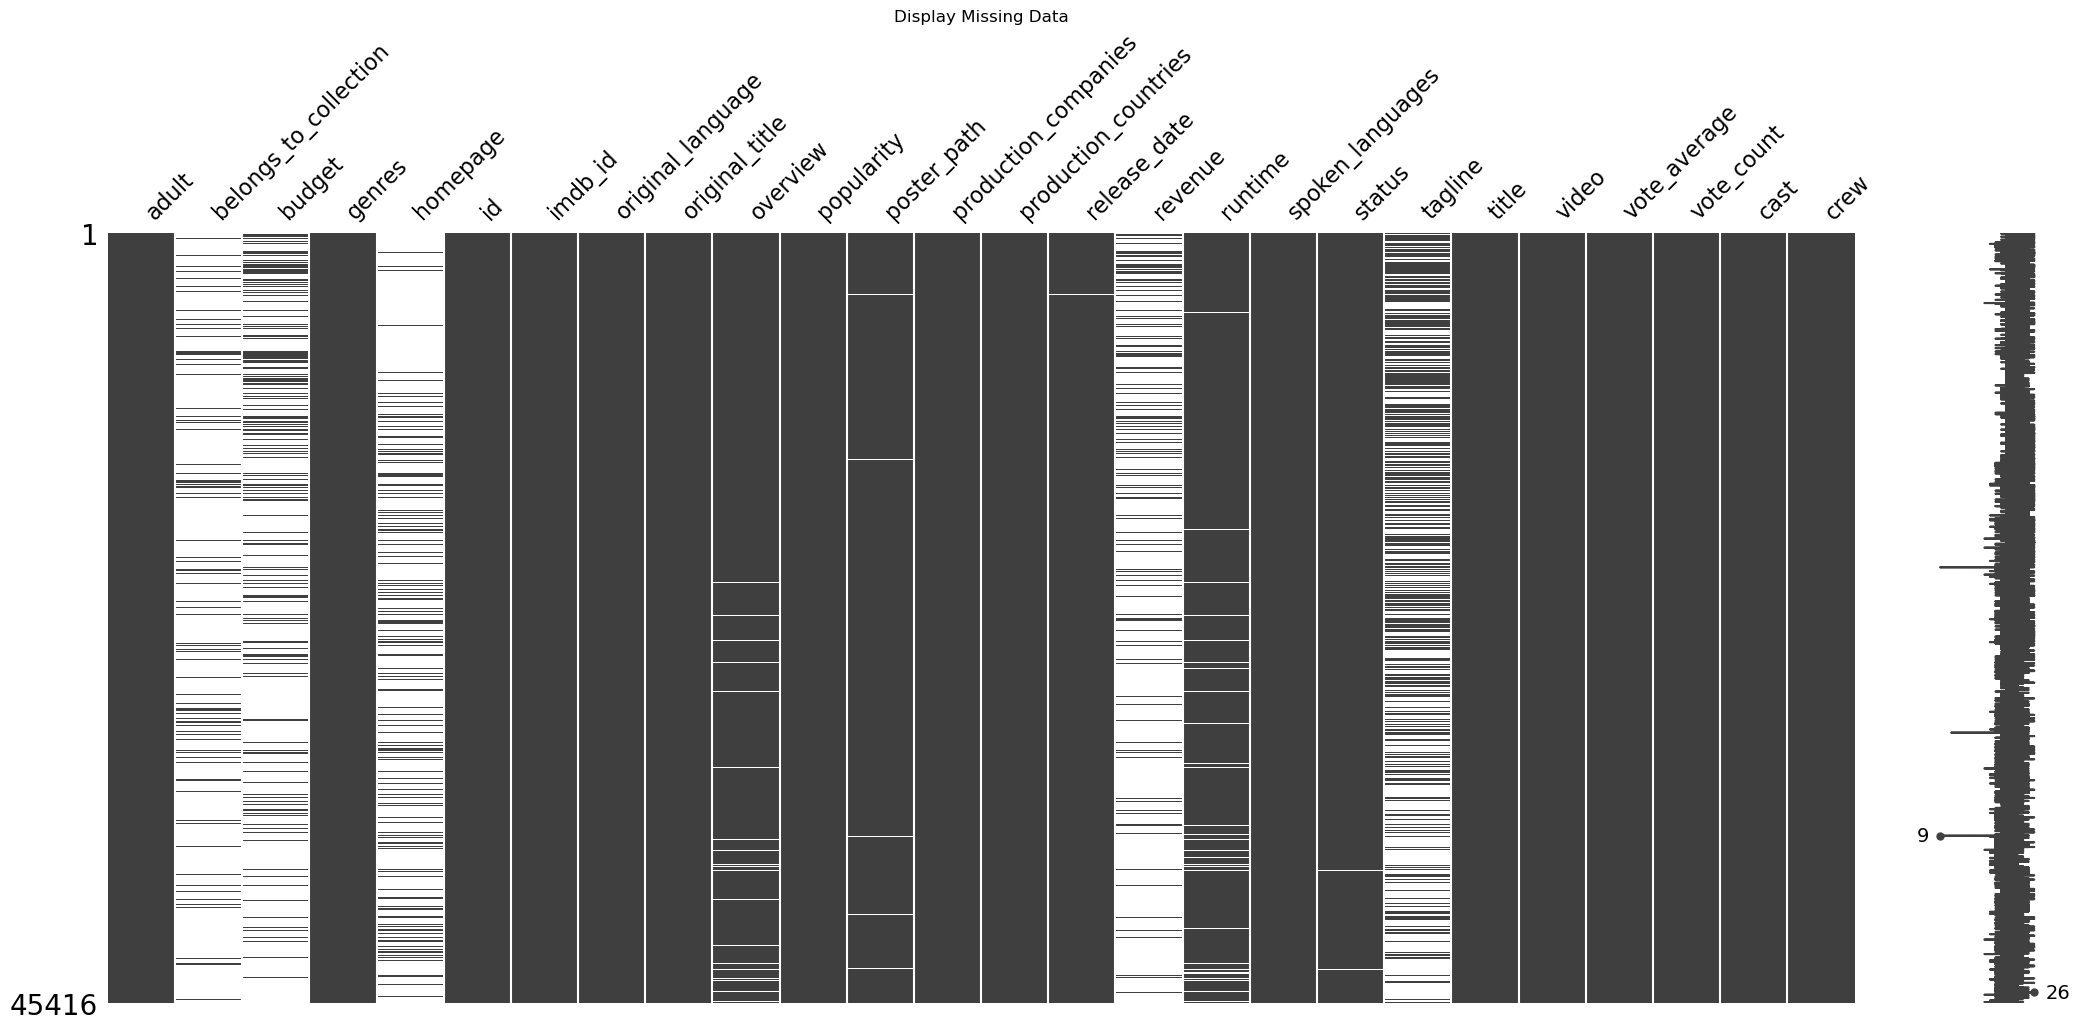

In [40]:
# A visual representation showing structure of missing data
msno.matrix(main_msn_to_zero)
plt.title("Display Missing Data")
plt.show()

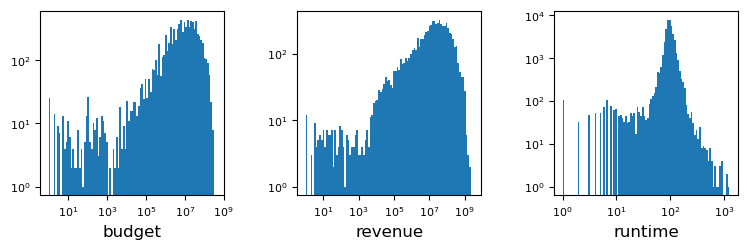

In [41]:
# Inspect distribution of observables
fig, axs = plt.subplots(1, len(sel), figsize=(3*len(sel), 3), sharex=False, sharey=False)

for i, var in enumerate(sel):
    axs[i].hist(main_msn_to_zero[var], bins=np.logspace(0,np.log10(np.amax(main_msn_to_zero[var])), 100), log = True);
    axs[i].semilogx()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_xlabel(var, fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

In [42]:
budget_cutoff = 1000
main_budget_cutoff = main_msn_to_zero.loc[main_msn_to_zero.budget >= budget_cutoff].copy()

#### Check for overlap in datasets

In [43]:
# Function to convert all strings to lower case and strip names of spaces
def clean_str(x):
    if isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''

In [44]:
# Check overlap between main dataset and thenumbers.com sample
# Remove spaces and make lowercase
thenumbers_full['clean_movie_title'] = thenumbers_full['movie_title'].apply(clean_str)
main_msn_to_zero['clean_original_title'] = main_msn_to_zero['original_title'].apply(clean_str)
thenumbers_full.loc[thenumbers_full.clean_movie_title.isin(main_msn_to_zero.clean_original_title)][['clean_movie_title', 'year','production_budget',
                                                                                                       'domestic_gross','worldwide_gross', 'domestic_box_office','international_box_office', 'movie_odid','genre', 'running_time','rating'
                                                                                                      ]].count()

clean_movie_title           5041
year                        4966
production_budget           5041
domestic_gross              5041
worldwide_gross             5041
domestic_box_office         1109
international_box_office    1109
movie_odid                  1109
genre                       1107
running_time                1027
rating                      1108
dtype: int64

In [45]:
# Check overlap between main dataset and staacked_imbd_genre dataset
stacked_imbd_genre.loc[(stacked_imbd_genre['gross(in $)'] > 0)*stacked_imbd_genre.movie_id.isin(main_msn_to_zero.imdb_id)][['movie_id', 'year', 'runtime',
                                                                                                                            'certificate', 'gross(in $)', 'genre',
                                                                                                                           'rating', 'description']].count()

movie_id       9886
year           9886
runtime           0
certificate    9618
gross(in $)    9886
genre          9886
rating         9886
description    9886
dtype: int64

In [46]:
# Check overlap between main dataset and enhanced_boxoffice
# Remove spaces and make lowercase
enhanced_boxoffice['clean_release_group'] = enhanced_boxoffice['Release Group'].apply(clean_str)
enhanced_boxoffice.loc[(enhanced_boxoffice['$Worldwide'] > 0)*enhanced_boxoffice.clean_release_group.isin(main_msn_to_zero.clean_original_title)][['clean_release_group', 'Year','$Worldwide','Genres', '$Domestic', '$Foreign']].count()

clean_release_group    2758
Year                   2758
$Worldwide             2758
Genres                 2735
$Domestic              2758
$Foreign               2758
dtype: int64

#### Combine information from datasets using merge

In [47]:
# Step zero: Drop duplicates in main dataset
main_msn_to_zero['year'] = main_msn_to_zero['release_date'].dt.year
enhanced_boxoffice['year'] = enhanced_boxoffice['Year'].astype(float)
main_msn_to_zero['clean_original_title'] = main_msn_to_zero['original_title'].apply(clean_str)
step_0 = main_msn_to_zero.loc[(main_msn_to_zero.year.isna() == 0)*(main_msn_to_zero.clean_original_title.isna() == 0)].drop_duplicates(subset = ['clean_original_title', 'year'], keep = False)

In [48]:
# Step 1: Left join step_1 and stacked_imdb data
step_1a = step_0.merge(stacked_imbd_genre[['movie_id', 'year', 'runtime',
                                           'certificate', 'gross(in $)', 'genre',
                                           'rating', 'description', 'director', 'star',
                                           'director_id', 'star_id']],
                                left_on=['imdb_id'], 
                                right_on = ['movie_id'], 
                                how = 'left',
                                suffixes = (None, "_imdb_genre"),
                                validate = 'one_to_one')

step1b = step_1a.merge(enhanced_boxoffice.drop_duplicates(subset = ['clean_release_group','year'], keep = False)[['clean_release_group', 'year',
                       '$Worldwide','Genres', '$Domestic', '$Foreign', 'Original_Language', 'Production_Countries']],
                       left_on=['clean_original_title', 'year'],
                       right_on = ['clean_release_group','year'],
                       how = 'left',
                       suffixes = (None, "_enhancedbo"),
                       validate = 'one_to_one')

In [49]:
# Step 2: Full merge main and thenumbers data
step_2 = step1b.merge(thenumbers_full[['movie_title', 'clean_movie_title', 'year', 'release_date', 'production_budget',
                                         'domestic_gross','worldwide_gross', 'movie_odid','genre', 'running_time','rating']],
                                left_on=['clean_original_title', 'release_date'],
                                right_on = ['clean_movie_title','release_date'],
                                how = 'outer',
                                suffixes = (None, "_thenumbers"),
                                indicator = True,
                                validate = 'one_to_one')

##### Compare data from the different datasets to see if they tend to agree with each other

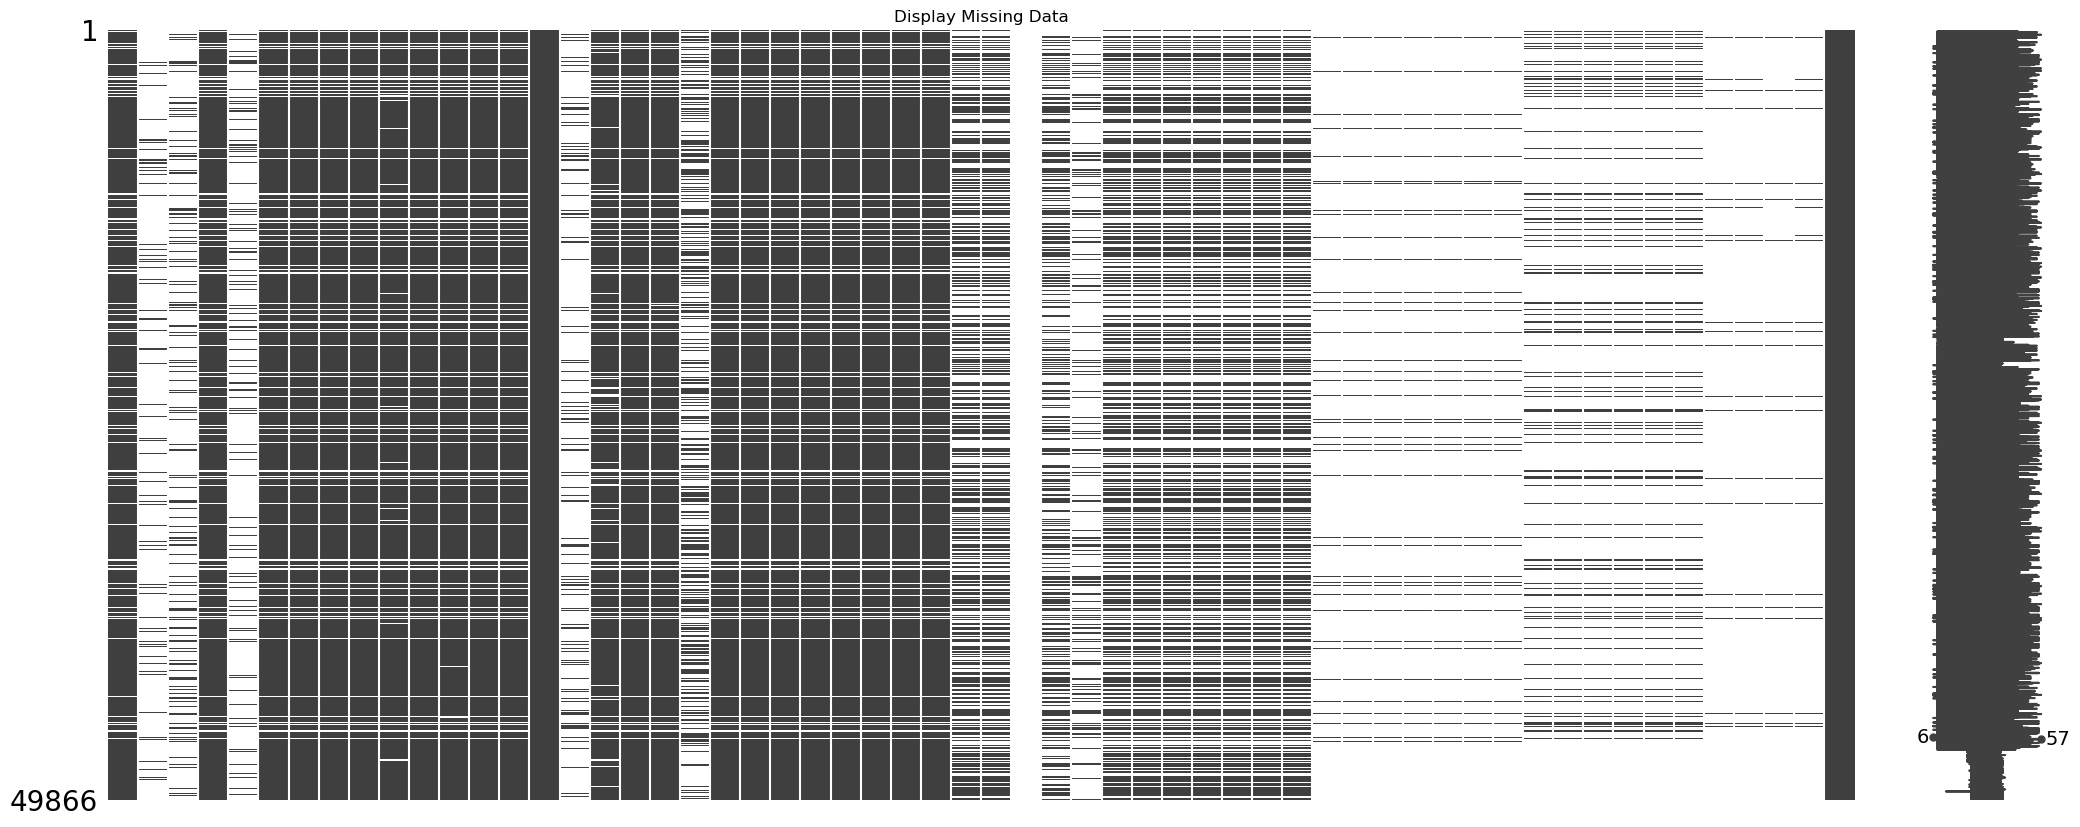

In [50]:
# Step 3: Build combined variables
msno.matrix(step_2)
plt.title("Display Missing Data")
plt.show()

Text(0, 0.5, 'production_budget from thenumbers')

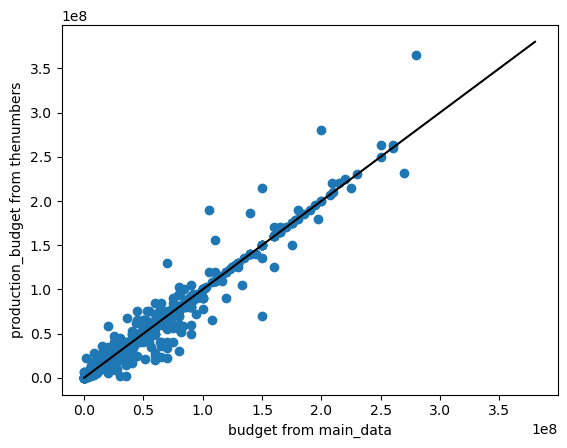

In [51]:
plt.scatter(step_2.budget, step_2.production_budget)
plt.plot(np.linspace(0,np.amax(step_2.budget), 100), np.linspace(0,np.amax(step_2.budget), 100), 'k-')
plt.xlabel("budget from main_data")
plt.ylabel("production_budget from thenumbers")
# We'll defer to the information in thenumbers

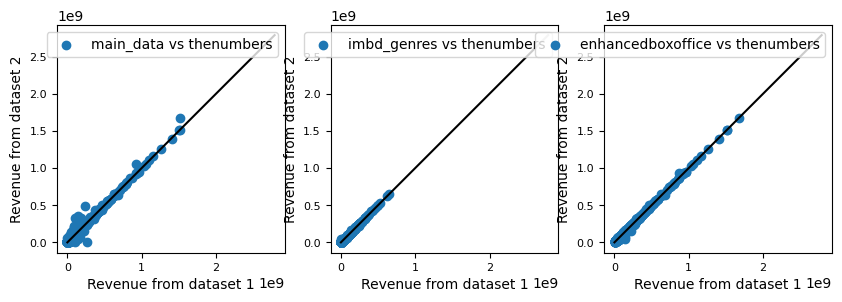

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

axs[0].scatter(step_2.revenue, step_2.worldwide_gross, label = "main_data vs thenumbers")
axs[1].scatter(step_2['gross(in $)'], step_2.domestic_gross, label = "imbd_genres vs thenumbers")
axs[2].scatter(step_2['$Worldwide'], step_2.worldwide_gross, label = "enhancedboxoffice vs thenumbers")

for ax in axs.flat:
    ax.plot(np.linspace(0,np.amax(step_2.revenue), 100), np.linspace(0,np.amax(step_2.revenue), 100), 'k-')
    ax.minorticks_off()
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_box_aspect(1)
    ax.set_xlabel("Revenue from dataset 1", fontsize = 10)
    ax.set_ylabel("Revenue from dataset 2", fontsize = 10)
    ax.legend()
# Notes: Revenue from main dataset matches total revenue in thenumbers, 
# and total revenue in the numbers matches total revenue in enhanced boxoffice
# while 'gross(in $)' in imdb_genres matches domestic revenue


#### Combine data variables

In [53]:
step_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49866 entries, 0 to 49865
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45288 non-null  object        
 1   belongs_to_collection  4482 non-null   object        
 2   budget                 8863 non-null   float64       
 3   genres                 45288 non-null  object        
 4   homepage               7754 non-null   object        
 5   id                     45288 non-null  float64       
 6   imdb_id                45287 non-null  object        
 7   original_language      45277 non-null  object        
 8   original_title         45288 non-null  object        
 9   overview               44350 non-null  object        
 10  popularity             45288 non-null  object        
 11  poster_path            44953 non-null  object        
 12  production_companies   45288 non-null  object        
 13  p

In [64]:
# Create combined data variables
step_3 = step_2.copy()
step_3.loc[:,'final_title'] = step_3['original_title'].fillna(step_3['movie_title'])
step_3.loc[:,'final_clean_title'] = step_3['clean_original_title'].fillna(step_3['clean_release_group']).fillna(step_3['clean_movie_title'])
step_3.loc[:,'final_budget'] = step_3['production_budget'].fillna(step_3['budget'])
step_3.loc[:,'final_worldwide_boxoffice'] = (step_3['worldwide_gross']).fillna(step_3['$Worldwide']).fillna(step_3['revenue'])
step_3.loc[:,'final_domestic_boxoffice'] = step_3['domestic_gross'].fillna(step_3['$Domestic']).fillna(step_3['gross(in $)'])
step_3.loc[:,'final_genres'] = step_3['genres'].fillna(step_3['genre']).fillna(step_3['genre_thenumbers']).fillna(step_3['Genres'])
step_3.loc[:,'final_runtime'] = step_3['runtime'].fillna(step_3['running_time'])
step_3.loc[:,'final_overview'] = step_3['overview'].fillna(step_3['description'])
step_3.loc[:,'final_rating'] = step_3['vote_average'].fillna(step_3['rating'])
step_3.loc[:,'final_certificate'] = step_3['rating_thenumbers'].fillna(step_3['certificate'])
step_3.loc[:,'final_original_language'] = step_3['original_language'].fillna(step_3['Original_Language'])
step_3.loc[:,'final_production_countries'] = step_3['production_countries'].fillna(step_3['Production_Countries'])
step_3.loc[:,'final_year'] = step_3['year_thenumbers'].fillna(step_3['year'])

/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_58732/2699601543.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_3.loc[:,'final_domestic_boxoffice'] = step_3['domestic_gross'].fillna(step_3['$Domestic']).fillna(step_3['gross(in $)'])
/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_58732/2699601543.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_3.loc[:,'final_rating'] = step_3['vote_average'].fillna(step_3['rating'])


In [69]:
# Select variables to keep
keep_variables = ['final_title', 'final_budget', 'final_worldwide_boxoffice', 
                  'final_domestic_boxoffice', 'final_genres', 'final_runtime',
                  'final_overview', 'final_certificate', 'final_original_language',
                  'final_rating', 'final_clean_title',
                  'final_production_countries','imdb_id', 'production_companies',
                  'release_date', 'final_year', 'cast', 'crew', 'director','director_id',
                  'star', 'star_id', '_merge']
combined_dataset = step_3[keep_variables]
combined_dataset.count()

final_title                   49866
final_budget                  13828
final_worldwide_boxoffice     12689
final_domestic_boxoffice      15047
final_genres                  46160
final_runtime                 44332
final_overview                44670
final_certificate             22650
final_original_language       45277
final_rating                  45288
final_clean_title             49866
final_production_countries    45288
imdb_id                       45287
production_companies          45288
release_date                  49717
final_year                    49717
cast                          45288
crew                          45288
director                      26729
director_id                   26729
star                          26719
star_id                       26722
_merge                        49866
dtype: int64

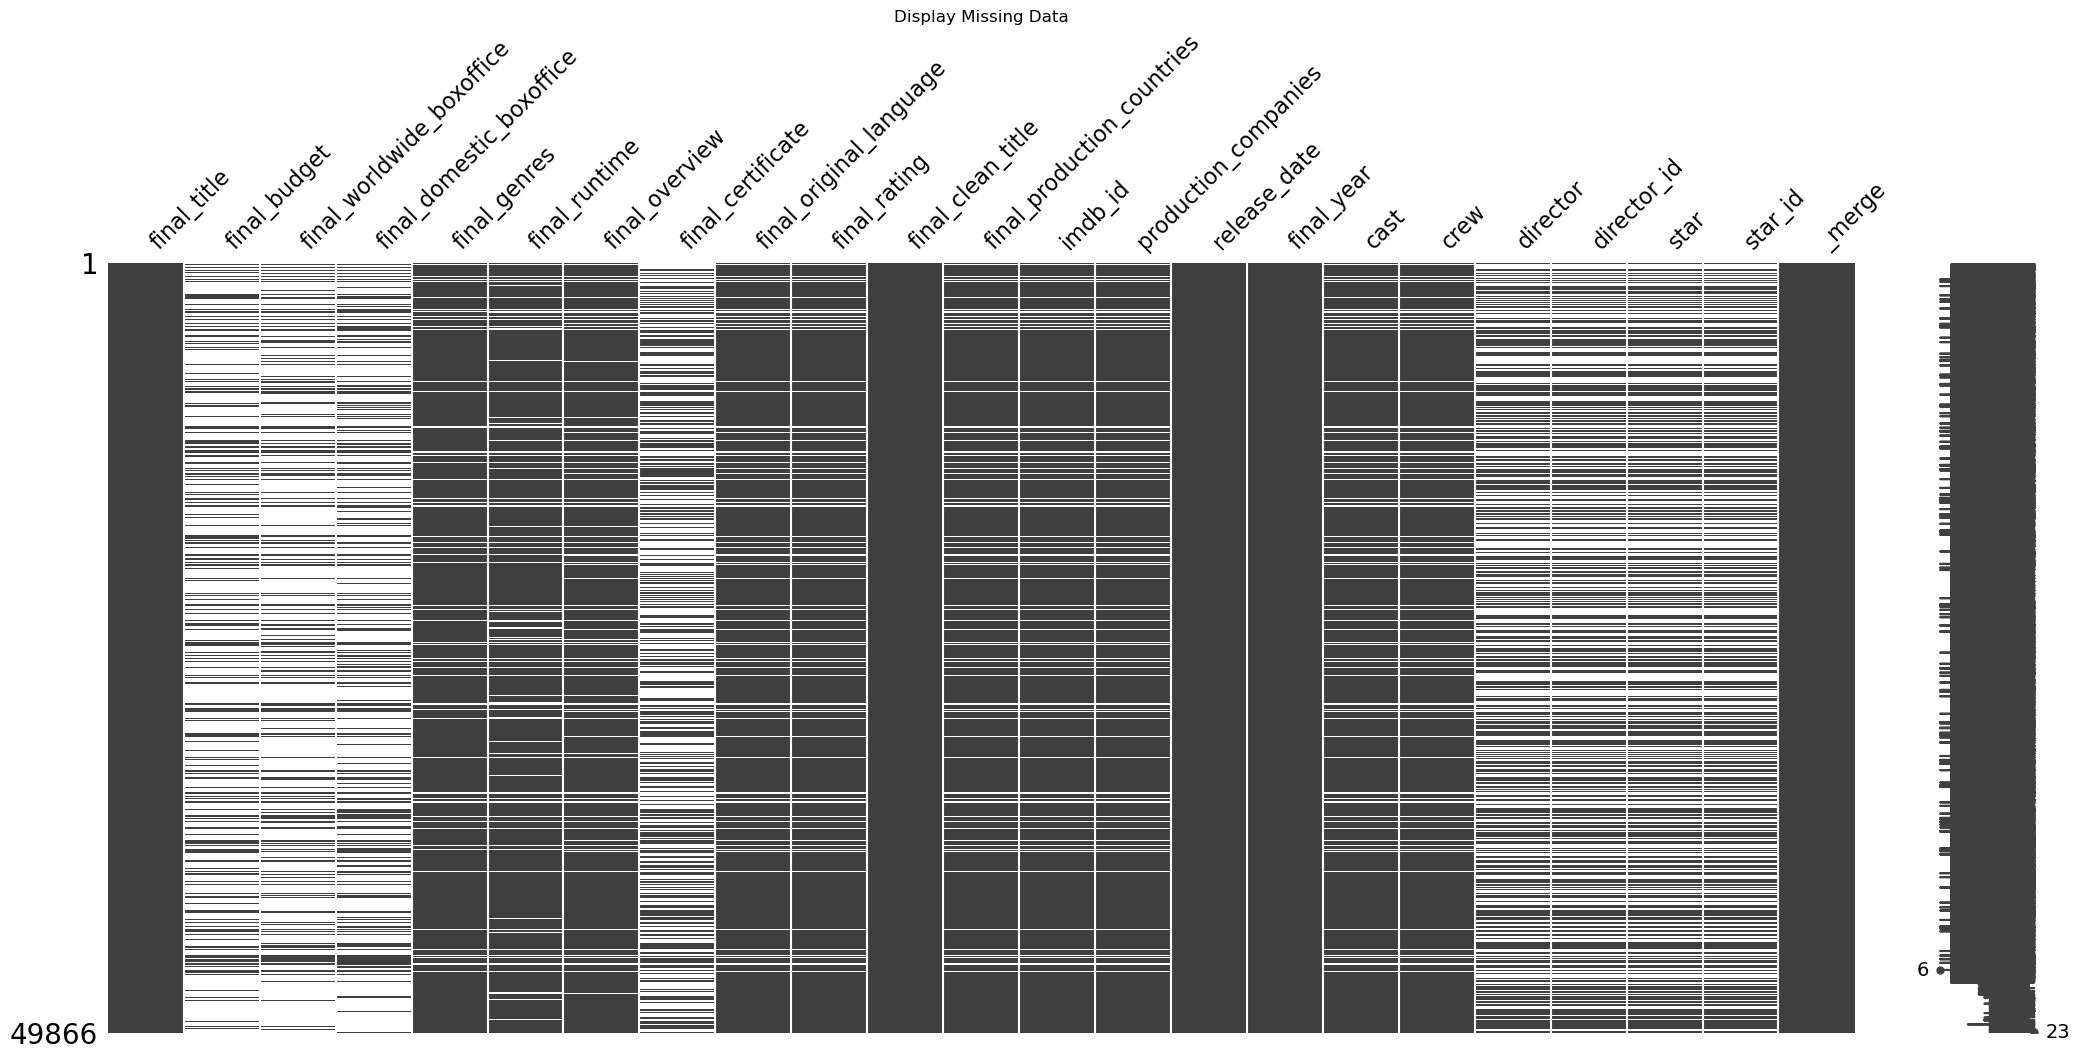

In [70]:
# Check completeness of dataset
msno.matrix(combined_dataset)
plt.title("Display Missing Data")
plt.show()

<Figure size 600x400 with 0 Axes>

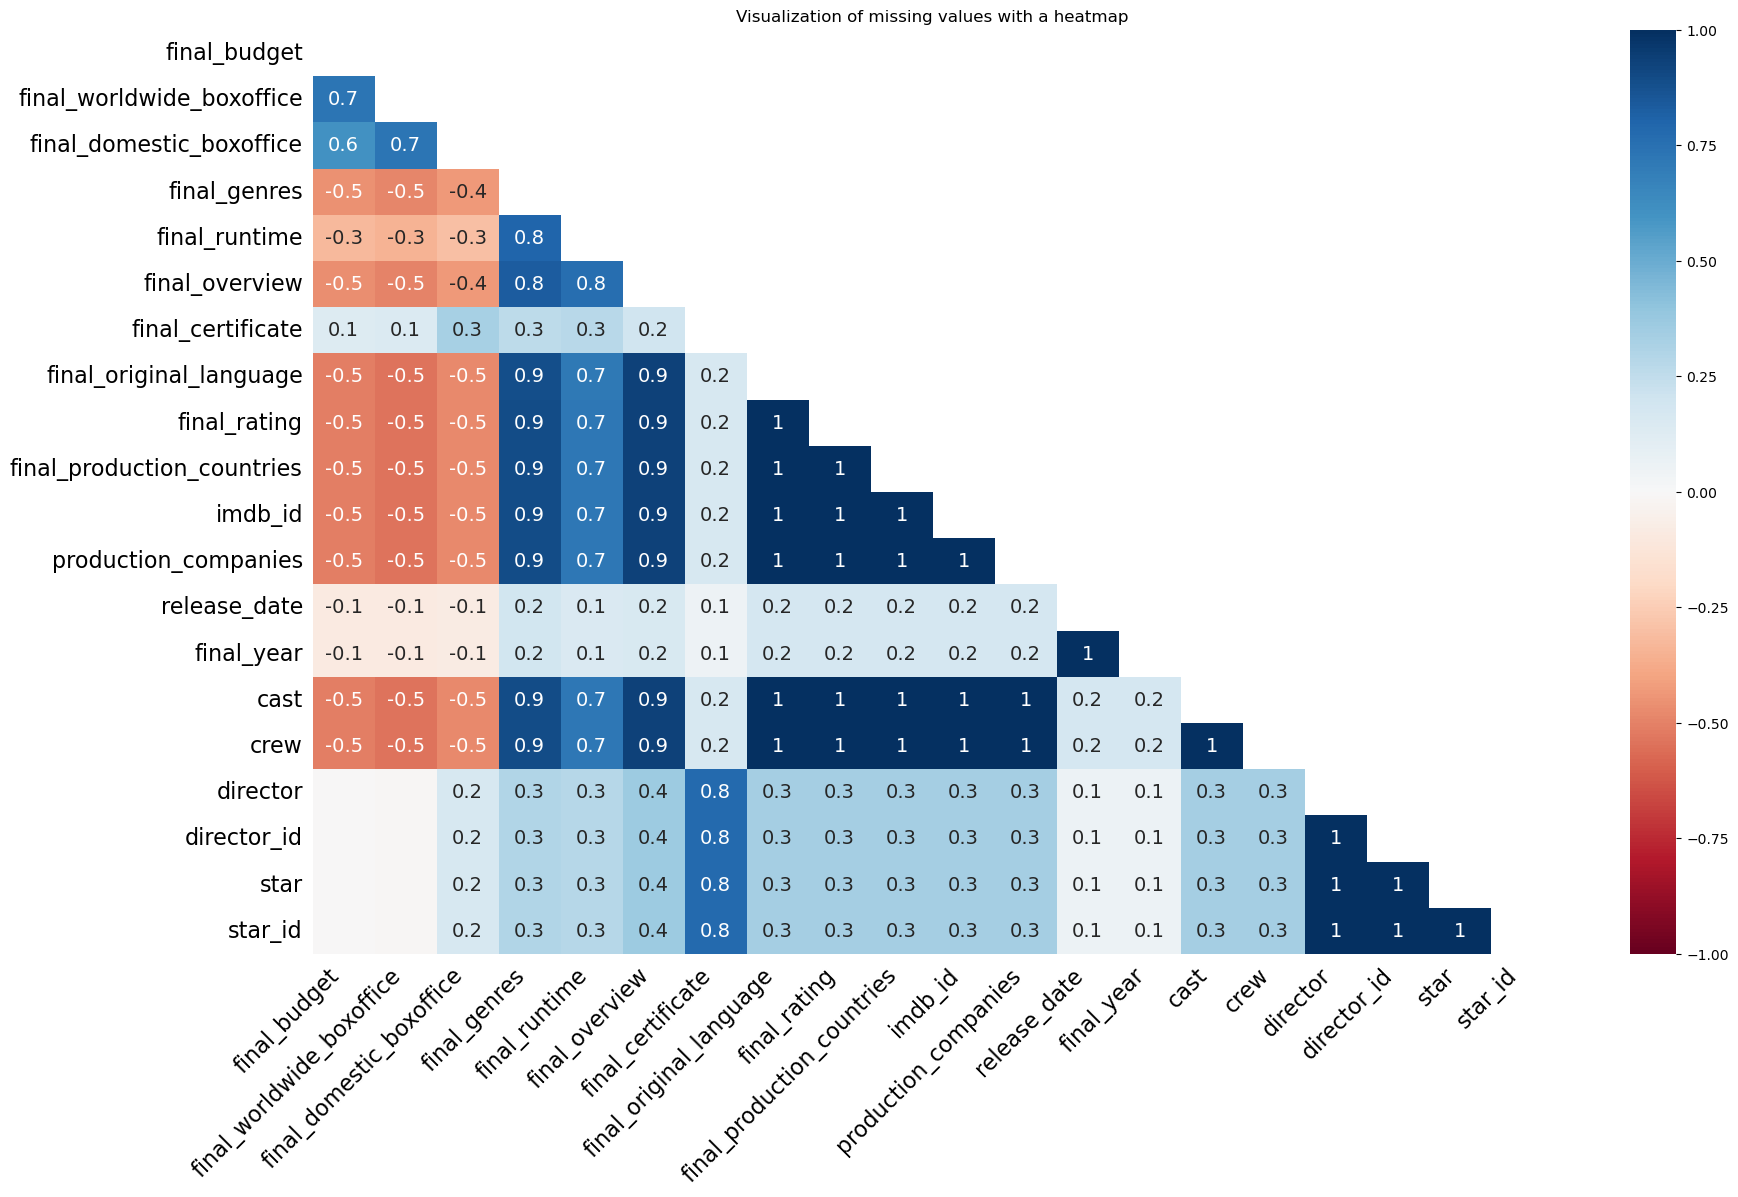

In [71]:
plt.figure(figsize=(6, 4))
msno.heatmap(combined_dataset)
plt.title("Visualization of missing values with a heatmap")
plt.show()

#### Export new dataset

In [72]:
with open('processed_data/combined_dataset.pkl', 'wb') as f:
    pickle.dump(combined_dataset, f)